# Gradient Triangle

In [4]:
!pip install pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 50.3 MB/s  0:00:00


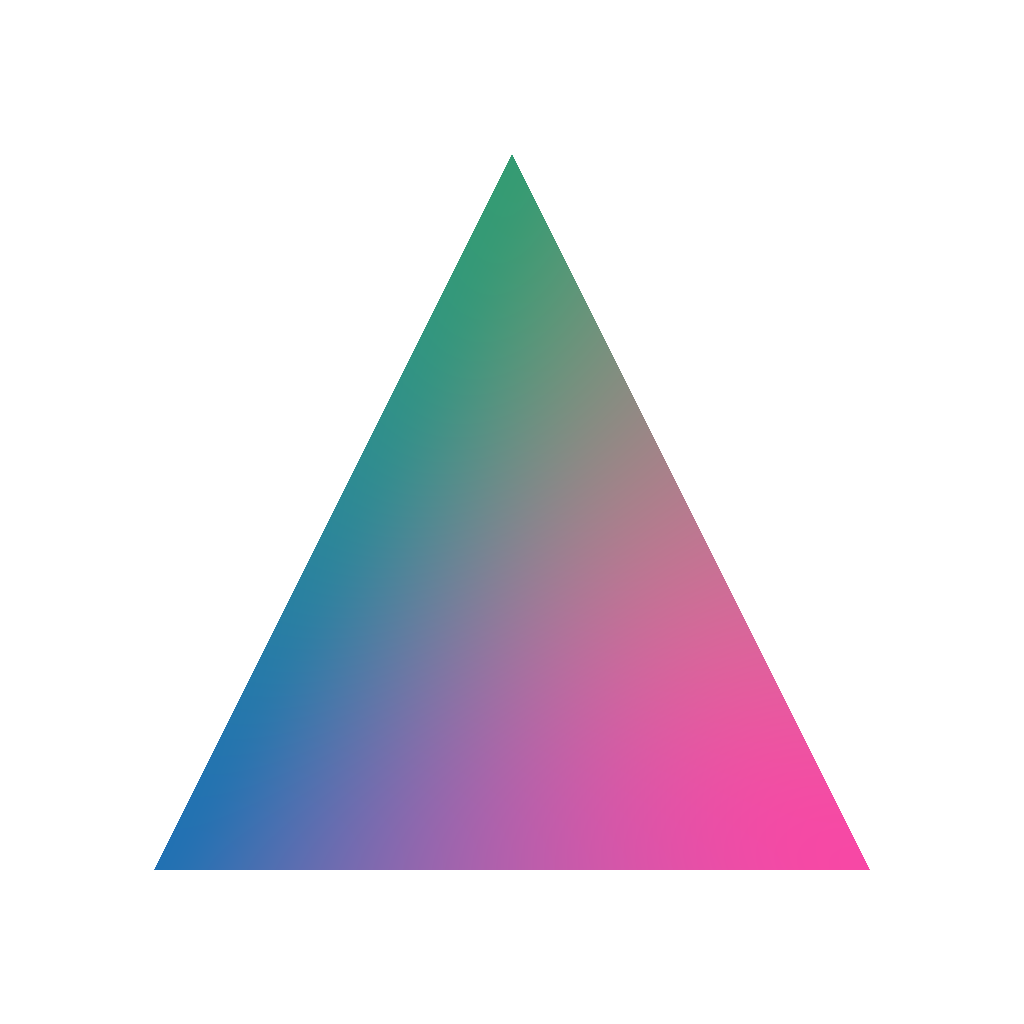

In [7]:
import math
from PIL import Image

# --- config ---
W, H = 1024, 1024

# Triangle corners (pixel coords)
A = (W * 0.15, H * 0.85)
B = (W * 0.85, H * 0.85)
C = (W * 0.50, H * 0.15)

# Corner colors — you can supply either an sRGB tuple (r,g,b) in the 0..1 range
# or a hex color string like "#F25973" or "F25973" or short form "F26".
colA = "#2271b2"  
colB = "#f748a5"  
colC = "#359b73"  

# A slightly more "pleasant" blend: blend in linear-light then convert back to sRGB
GAMMA = 2.2
SMOOTH = 1.0  # 0 to disable, ~0.5-1.5 is subtle

# --- helpers ---
def clamp01(x: float) -> float:
    return 0.0 if x < 0.0 else (1.0 if x > 1.0 else x)


def srgb_to_linear(c: float) -> float:
    # simple gamma approximation (good enough for this)
    return c ** GAMMA


def linear_to_srgb(c: float) -> float:
    return clamp01(c) ** (1.0 / GAMMA)


def smoothstep(t: float) -> float:
    t = clamp01(t)
    return t * t * (3.0 - 2.0 * t)


def barycentric(px: float, py: float, A, B, C):
    ax, ay = A
    bx, by = B
    cx, cy = C
    v0x, v0y = bx - ax, by - ay
    v1x, v1y = cx - ax, cy - ay
    v2x, v2y = px - ax, py - ay
    denom = v0x * v1y - v1x * v0y
    if denom == 0:
        return None
    inv = 1.0 / denom
    wB = (v2x * v1y - v1x * v2y) * inv
    wC = (v0x * v2y - v2x * v0y) * inv
    wA = 1.0 - wB - wC
    return (wA, wB, wC)


# New: accept hex strings or (r,g,b) tuples
def hex_to_srgb(h):
    """Convert a hex color ("#RRGGBB", "RRGGBB" or short "RGB") to an (r,g,b)
    tuple with values in 0..1. If input is already a 3-tuple, it is returned unchanged."""
    if isinstance(h, tuple) and len(h) == 3:
        return h
    s = str(h).strip()
    if s.startswith('#'):
        s = s[1:]
    if len(s) == 3:
        s = ''.join([c * 2 for c in s])
    if len(s) != 6:
        raise ValueError(f"Invalid hex color: {h!r}")
    r = int(s[0:2], 16) / 255.0
    g = int(s[2:4], 16) / 255.0
    b = int(s[4:6], 16) / 255.0
    return (r, g, b)


# --- render ---
# ensure colors are sRGB tuples (0..1)
colA = hex_to_srgb(colA)
colB = hex_to_srgb(colB)
colC = hex_to_srgb(colC)

img = Image.new("RGBA", (W, H), (0, 0, 0, 0))
pix = img.load()

# preconvert corner colors to linear
linA = tuple(srgb_to_linear(x) for x in colA)
linB = tuple(srgb_to_linear(x) for x in colB)
linC = tuple(srgb_to_linear(x) for x in colC)

for y in range(H):
    py = y + 0.5
    for x in range(W):
        px_ = x + 0.5
        w = barycentric(px_, py, A, B, C)
        if w is None:
            continue
        wA, wB, wC = w

        # inside triangle test (with a tiny tolerance)
        if wA < -1e-6 or wB < -1e-6 or wC < -1e-6:
            continue

        # Optional smoothing to soften the center mix a bit (subtle, aesthetic)
        if SMOOTH != 0.0:
            wA = smoothstep(wA) ** SMOOTH
            wB = smoothstep(wB) ** SMOOTH
            wC = smoothstep(wC) ** SMOOTH
            s = wA + wB + wC
            wA, wB, wC = wA / s, wB / s, wC / s

        # linear-light blend
        r_lin = wA * linA[0] + wB * linB[0] + wC * linC[0]
        g_lin = wA * linA[1] + wB * linB[1] + wC * linC[1]
        b_lin = wA * linA[2] + wB * linB[2] + wC * linC[2]

        # back to sRGB
        r = int(round(255 * linear_to_srgb(r_lin)))
        g = int(round(255 * linear_to_srgb(g_lin)))
        b = int(round(255 * linear_to_srgb(b_lin)))

        pix[x, y] = (r, g, b, 255)

img

In [8]:
img.save("triangle_gradient.png")